# Job Classification

Using the reuters data available in NLTK we are going to analyse the classification of the documents in the dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,pandas_profiling -g

import re
from tqdm import tqdm
import tarfile
import yaml
import watermark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas.plotting import register_matplotlib_converters    # for pandas_profiling

register_matplotlib_converters()                              # for pandas_profiling

CPython 3.7.3
IPython 7.5.0

numpy 1.16.4
pandas 0.24.2
pandas_profiling unknown

compiler   : GCC 7.3.0
system     : Linux
release    : 5.0.0-20-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : cc154234348de1ab3cb482ee1843bb4eb670cba6


### Constants

In [2]:
Output_DATA = "../data/processed/reuters.csv"

### Load Data

In [3]:
import nltk
nltk.download('reuters')

[nltk_data] Downloading package reuters to /home/greg/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [4]:
from nltk.corpus import reuters

 
def collection_stats(verbose=True):
    # List of categories
    categories = reuters.categories()
    
    # Documents: a category can be requested (ex: reuters.fileids('barley'))
    documents = reuters.fileids()
    
    df = pd.DataFrame()
    df['documents'] = documents
    df['text'] = df['documents'].apply(reuters.raw)
    df['categories'] = df['documents'].apply(reuters.categories)
    
    if verbose:
        print('Reuters data:')
        print(str(df.shape[0]) + "\t documents")
 
        train_docs = list(filter(lambda doc: doc.startswith("train"), df['documents'].values))
        print(str(len(train_docs)) + "\t total train documents")

        test_docs = list(filter(lambda doc: doc.startswith("test"), df['documents'].values))
        print(str(len(test_docs)) + "\t total test documents")

        print(str(len(categories)) + "\t categories\n")
 
        # Words for a document
        document_id = df['documents'][0]

        document_words = reuters.words(document_id)
        print('Words for doc 0:')
        print(document_words[:50]);  

        # Raw document
        print('\nRaw doc:')
        print(reuters.raw(document_id)[:150])
        
    return df, categories


In [5]:
df, categories = collection_stats()

Reuters data:
10788	 documents
7769	 total train documents
3019	 total test documents
90	 categories

Words for doc 0:
['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', '.', 'S', '.-', 'JAPAN', 'RIFT', 'Mounting', 'trade', 'friction', 'between', 'the', 'U', '.', 'S', '.', 'And', 'Japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'Asia', "'", 's', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', '-', 'reaching', 'economic', 'damage', ',', 'businessmen', 'and', 'officials', 'said', '.', 'They']

Raw doc:
ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT
  Mounting trade friction between the
  U.S. And Japan has raised fears among many of Asia's exportin


In [6]:
df.head(3)

documents                                               text  \
0  test/14826  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...   
1  test/14828  CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...   
2  test/14829  JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...   

         categories  
0           [trade]  
1           [grain]  
2  [crude, nat-gas]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10788 entries, 0 to 10787
Data columns (total 3 columns):
documents     10788 non-null object
text          10788 non-null object
categories    10788 non-null object
dtypes: object(3)
memory usage: 252.9+ KB


In [8]:
df.describe()

documents                            text categories
count        10788                           10788      10788
unique       10788                           10657        468
top     test/21140  26-FEB-1987\n  26-FEB-1987\n\n     [earn]
freq             1                               7       3923

In [9]:
base = np.zeros(len(categories))
def count_categories(cat, cat_list=categories, base=base):
    base = base.copy()
    for x in cat:
        idx = cat_list.index(x)
        base[idx] += 1
    return base

In [10]:
cat_by_freq = df.categories.apply(count_categories).sum(axis=0)

In [11]:
df_categories = pd.DataFrame({'categories': categories, 'frequency': cat_by_freq})
df_categories.sort_values(by=['frequency'], ascending=False, inplace=True)
df_categories.reset_index(drop=True, inplace=True)
df_categories[:10]

categories  frequency
0       earn     3964.0
1        acq     2369.0
2   money-fx      717.0
3      grain      582.0
4      crude      578.0
5      trade      485.0
6   interest      478.0
7       ship      286.0
8      wheat      283.0
9       corn      237.0

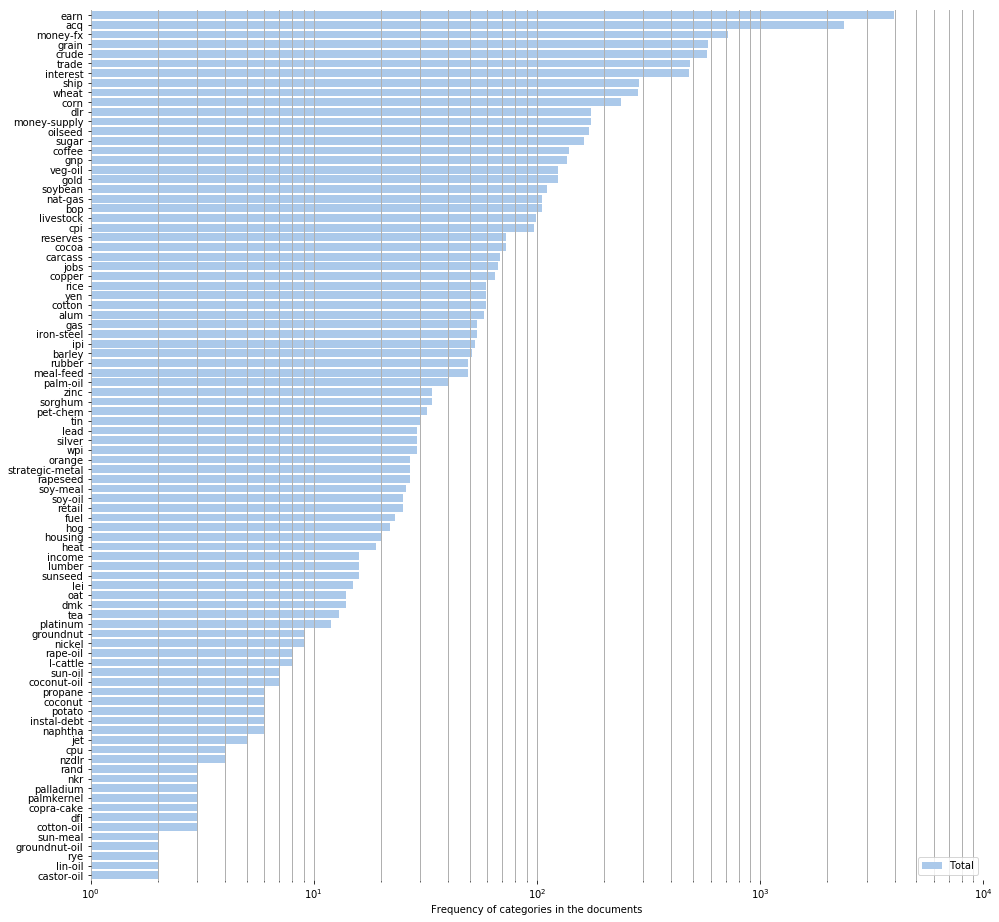

In [12]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))
# Log scale
ax.set_xscale('log')

# Plot the total crashes
sns.set_color_codes("pastel")
g = sns.barplot(x="frequency", y="categories", data=df_categories,
            label="Total", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(1, 10000), ylabel="", xlabel="Frequency of categories in the documents")
ax.grid(linestyle='-', linewidth=1, which='both', axis='x')
sns.despine(left=True, bottom=True)

Clean up the documents.<br>
Remove accents and special characters, normalize the text, remove stopwords, lematize...

In [13]:
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer
from wordcloud import WordCloud

nltk.download('wordnet')

stop_word_list = stopwords.words('english')
stop_word_list.remove('no')
stop_word_list.remove('not')

lemma = WordNetLemmatizer()
token = ToktokTokenizer()

[nltk_data] Downloading package wordnet to /home/greg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [45]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"I'm", 'I am ', text)
    text = re.sub(r"\'s", ' ', text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'", " ", text)
    text = re.sub(r"@", " ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"let\'s", "let us", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"y\'all", "you all", text)
    text = re.sub(r"doin\'", "doing", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = text.replace("\n", " ")
    text = text.replace("U.S.", "United States")
    # Extend with other cleaning text operations...
    return text

In [46]:
# Function to remove accents and normalize the text
def remove_accents(data):
    data = unicodedata.normalize('NFKD', data).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return data

In [67]:
# Remove special characters and digits
def remove_special(text):
    str = "`1234567890-=~@#$%^&*()_+[!{;”:\’'><.,/?”}]"
    for w in text:
        if w in str:
            text = text.replace(w, ' ')
    return text

def remove_stop_words_lemitize(text):
    word_list = [x.lower().strip() for x in token.tokenize(text)]
    removedList = [x for x in word_list if not x in stop_word_list]
    
    # Reduce variations for inflections and derivations
    listLemma = []
    for w in removedList:
        x = lemma.lemmatize(w, 'v')
        listLemma.append(x)
    text = ' '.join(listLemma)
    return text

In [68]:
def text_pre_process(text):
    text = remove_accents(text)
    text = remove_special(text)
    text = remove_stop_words_lemitize(text)
    return(text)

In [69]:
df['processed_text'] = df['text'].map(lambda t: clean_text(t))
df['processed_text'] = df['processed_text'].map(lambda t: text_pre_process(t))

### Visual Representation of the words

In [70]:
all_text = ''
for x in df['processed_text']:
    all_text = all_text + ' ' + x

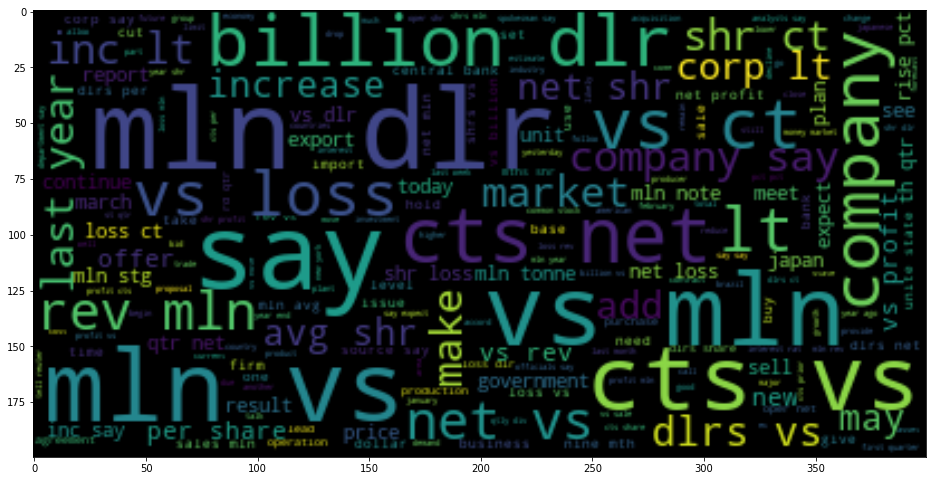

In [71]:
wc = WordCloud(background_color='black', max_font_size=50).generate(all_text)
plt.figure(figsize=(16, 12))
plt.imshow(wc, interpolation='bilinear')

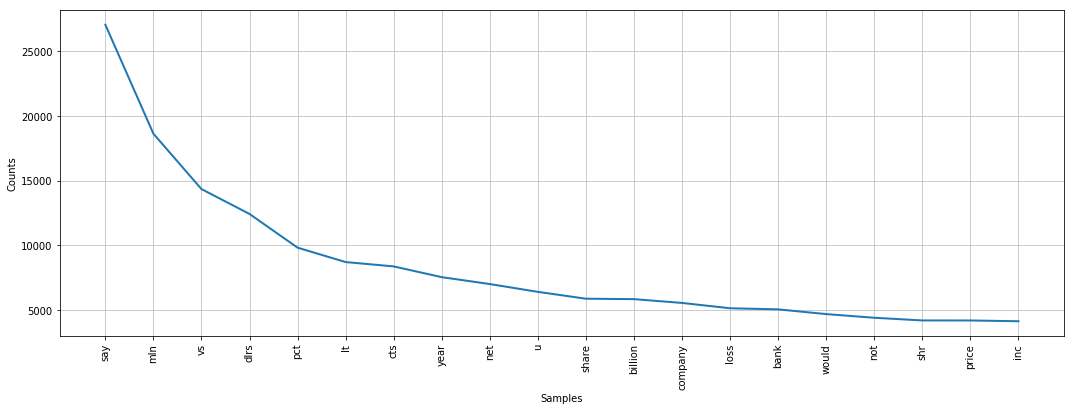

In [72]:
word_freq_dist = nltk.FreqDist(ToktokTokenizer().tokenize(all_text))
plt.figure(figsize=(18, 6))
word_freq_dist.plot(20)

Plot the distribution of number of words per entry in the dataset

In [73]:
df['n_words'] = df['processed_text'].str.split(' ').apply(len)

Text(0, 0.5, 'Count')

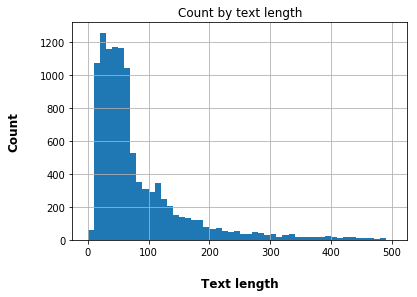

In [74]:
ax = df['n_words'].hist(bins=50, range=[0, 500])
ax.set_title("Count by text length")
ax.set_xlabel("Text length", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Count", labelpad=20, weight='bold', size=12)

Count the number of words per genre

In [58]:
# To calculate for all genres....
# cfd = nltk.ConditionalFreqDist(
#     (genre, word)
#      for genre in reuters.categories()
#      for word in reuters.words(categories=genre))

In [65]:
genres = df_categories['categories'][0]
genres = [genres]

In [66]:
cfd = nltk.ConditionalFreqDist(
    (genre, word)
    for genre in genres
    for word in reuters.words(categories=genre))

### Extract features vectors

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

X_all = df['processed_text']

Now we want to weight each of feature as per its “importance” for the document.<br>
To explain in a simple way what "tf-idf" does, the terms weight is higher the more common the term is in the document, and the more uncommon in the collection. More detailed explenation at https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [82]:
def tf_idf(docs):
    tfidf = TfidfVectorizer(tokenizer=token.tokenize, min_df=3,
                            max_df=0.90, max_features=3000,
                            use_idf=True, sublinear_tf=True,
                            norm='l2');
    tfidf.fit(docs);
    return tfidf;

In [83]:
def feature_values(doc, representer):
    doc_representation = representer.transform([doc])
    features = representer.get_feature_names()
    return [(features[index], doc_representation[0, index])
                 for index in doc_representation.nonzero()[1]]

In [84]:
train_docs = []
test_docs = []
for doc_id in reuters.fileids():
    if doc_id.startswith("train"):
        train_docs.append(reuters.raw(doc_id))
    else:
        test_docs.append(reuters.raw(doc_id))

In [85]:
representer = tf_idf(train_docs)

for doc in test_docs:
    print(feature_values(doc, representer))

[('yesterday', 0.03836978667858468), ('year.', 0.03246619114861282), ('year', 0.04210805376653159), ('would', 0.05156708703838996), ('world', 0.060468060830710005), ('with', 0.043043887480750574), ('will', 0.04549476270432139), ('whose', 0.055865525231259025), ('whole', 0.05403723866506281), ('who', 0.03871710435062293), ('while', 0.0337236008250724), ('which', 0.02341050888812093), ('where', 0.0462181935001944), ('week', 0.03313390205267981), ('we', 0.07998304857552303), ('washington', 0.047372688657664974), ('was', 0.021750073527026098), ('want', 0.04861062245384652), ('view', 0.051502965784550256), ('very', 0.07035696548143883), ('us', 0.050405615226640416), ('up', 0.027902992847689344), ('u.s.', 0.09513096561233628), ('two', 0.04506200678276534), ('trading', 0.0384752957348651), ('trade', 0.11429833993221211), ('tough', 0.06056431784035102), ('told', 0.029969781546929197), ('tokyo', 0.08487284969617549), ('to', 0.0569157893095974), ('time', 0.0369144673331631), ('threat', 0.0597680

[('yen.', 0.17154483446481372), ('yen', 0.27151467576022625), ('year', 0.10236313456188673), ('will', 0.06531983814842707), ('when', 0.1037678328076494), ('to', 0.06819112868036047), ('the', 0.11872773839768533), ('spokesman', 0.10796858277181477), ('slow', 0.16004046516200443), ('since', 0.10554006017830932), ('said.', 0.057781866802524014), ('s', 0.05591918697899886), ('profit', 0.09231557236401183), ('plans', 0.11392507665769275), ('pay', 0.09850813881409351), ('parent', 0.1578568290822199), ('paid', 0.22128080758478355), ('of', 0.03766054540276976), ('october', 0.14600431718037285), ('no', 0.1942475964062554), ('motor', 0.17859449466414562), ('mark', 0.1467049272417818), ('ltd', 0.10731217931375606), ('loss', 0.08527008501060908), ('it', 0.08587443748490539), ('is', 0.05984181997570069), ('interim', 0.1793315040452919), ('in', 0.07078016504759338), ('has', 0.06633132371187599), ('half', 0.254926112316017), ('had', 0.07881967186366087), ('for', 0.04796717604009186), ('five', 0.09642

[('year.', 0.06926319470010209), ('year', 0.08983309169601374), ('well', 0.17470508364287024), ('was', 0.04640148795243917), ('versus', 0.1896627230924266), ('up', 0.0595280923924345), ('throughout', 0.12270293193599384), ('through', 0.07763417241566893), ('this', 0.088867365555881), ('the', 0.09123492338990069), ('that', 0.046239284298755984), ('stronger', 0.12145989897957839), ('strong', 0.214441924828982), ('significantly', 0.1147004104929324), ('share.', 0.08546472260275165), ('share', 0.10060327219655653), ('second', 0.08533123845423204), ('sales', 0.06426102305171745), ('said.', 0.06926941995498849), ('said', 0.06545949240439049), ('s', 0.06703642268305177), ('reported', 0.13253837068775218), ('quarter.', 0.10135791451205581), ('quarter', 0.173427154159424), ('programs', 0.12313497633895062), ('products', 0.08197012409286453), ('prices', 0.06896644941626563), ('position', 0.09834572334443825), ('placed', 0.12313497633895062), ('pct', 0.044173095311105054), ('paying', 0.1191832061

[('year', 0.05843393775911006), ('would', 0.042264707956635755), ('with', 0.05973260735122056), ('will', 0.037287792847851005), ('which', 0.06817781062503306), ('whether', 0.1248011213812936), ('when', 0.05923580896220028), ('we', 0.05765160773921653), ('was', 0.08927343161512526), ('used', 0.07468240499661637), ('u.s.', 0.08958362041176773), ('told', 0.05154909699699854), ('to', 0.07079893232816047), ('this', 0.04231690543281304), ('they', 0.049798272886300746), ('them.', 0.09858746046231978), ('the', 0.0759815750679838), ('that', 0.09728018283172243), ('textile', 0.34482681004753857), ('takeover', 0.07858847375304047), ('stock', 0.0508613056304896), ('starting', 0.09392791339335255), ('stake', 0.11069420185195337), ('spokesman', 0.10435510268079727), ('sharply', 0.0800245789155192), ('say', 0.07141114802664922), ('sales', 0.051810041743191905), ('said.', 0.055848029940424794), ('said', 0.07020769686950211), ('s', 0.03192143641806264), ('rumors', 0.21963303686711733), ('rose', 0.05814

[('york', 0.09106124745479523), ('vs', 0.1335280425660341), ('u.s.', 0.05375032910397774), ('texas', 0.10429479387954114), ('tax', 0.18160248551661248), ('series', 0.2425741017503758), ('securities', 0.07918577411754206), ('record', 0.17954536547954572), ('qtly', 0.08130853172541856), ('prior', 0.2035219327553428), ('pay', 0.1976771259550198), ('of', 0.027070290217987434), ('new', 0.059305577302080546), ('national', 0.07813497895160473), ('mutual', 0.1268617979991892), ('may', 0.21700777588080122), ('income', 0.2085260366588203), ('government', 0.06983600693515161), ('fund', 0.2512334204964334), ('free', 0.249262804394072), ('dividends', 0.11795510711855645), ('div', 0.21234689973398463), ('daily', 0.2717333871057181), ('cts', 0.1634207922017568), ('co', 0.06379909926730146), ('california', 0.11891881178455334), ('bond', 0.11673715597517666), ('april', 0.06140921162532167), ('and', 0.029652095844708588), ('9', 0.1250064630834866), ('6.7', 0.31301349299756887), ('6.2', 0.225282181770207

[('would', 0.07655894814469204), ('working', 0.07171495603840759), ('work', 0.06646265241573193), ('who', 0.09732422170696638), ('whether', 0.06362234170628624), ('where', 0.06861772659154652), ('when', 0.05112934130752763), ('were', 0.037614022267060995), ('weeks', 0.0678335785018311), ('we', 0.04976193928417674), ('was', 0.06776669409126336), ('want', 0.07216964031640276), ('up', 0.07014050011600938), ('under', 0.04653572681972527), ('two', 0.08292230907827843), ('toward', 0.08319251804847697), ('told', 0.04449456199941944), ('to', 0.06344738994002842), ('time', 0.09279288477753965), ('they', 0.09020536461553715), ('there', 0.048516446339341955), ('their', 0.0474515451004372), ('the', 0.08377933187865093), ('that', 0.0839673122998247), ('terminated', 0.09076421554841745), ('target', 0.06600919722993982), ('talks.', 0.09263102571252535), ('talks', 0.10054371810273142), ('takeover', 0.0678335785018311), ('t', 0.1093702681842322), ('still', 0.05681070076975689), ('statement', 0.05844290

[('york', 0.1279699172873241), ('will', 0.06598203417392437), ('was', 0.11208614922713461), ('today', 0.09789286020879495), ('to', 0.08537800038157838), ('the', 0.08543690561723045), ('that', 0.11169433457346328), ('support', 0.13298389787531184), ('speaking', 0.16447112234364578), ('says', 0.1105011762101511), ('said.', 0.058367644777899595), ('said', 0.04450058822980184), ('s', 0.05648608157666138), ('reached', 0.1351728167060129), ('production', 0.10746221922938272), ('producers', 0.129922052519204), ('prices', 0.09839277242065553), ('one', 0.07903533250136797), ('of', 0.07983611907112159), ('october', 0.14748447208098048), ('no', 0.09349837058967515), ('next', 0.11194767571853435), ('new', 0.08334313480376776), ('national', 0.1098044126690374), ('mln', 0.0520805071849342), ('may', 0.08975106287832384), ('market', 0.14875428937505458), ('manager', 0.15910546977485931), ('lb', 0.18792463829919387), ('is', 0.06044848123619539), ('international', 0.09513866661503194), ('in', 0.07149771

[('year', 0.09517789008163535), ('world', 0.10005521594988966), ('with', 0.1499459181753424), ('which', 0.06558722532519358), ('western', 0.1319662074046063), ('west', 0.2240741678563513), ('turnover', 0.13349600648088725), ('trade', 0.2253459149496298), ('to', 0.07858829656349375), ('the', 0.11539770169565822), ('surplus', 0.11982344077031605), ('statistics', 0.1280058370768318), ('soviet', 0.2793361248606759), ('showed', 0.13141465472871441), ('s', 0.08803351788336707), ('rise', 0.09548654279305123), ('purchases', 0.13087439744457383), ('published', 0.15950347230616727), ('price', 0.09068437032886448), ('previous', 0.10963965276730132), ('pct.', 0.09977954320039299), ('oil', 0.08928458574248357), ('official', 0.09875749653403411), ('of', 0.035017013362287866), ('needed', 0.1336936227013522), ('moscow', 0.28003023122169485), ('monthly', 0.14148225584610505), ('mln', 0.047938793665046844), ('main', 0.12400770190783635), ('last', 0.07055973877944266), ('in', 0.09275415449175596), ('hit'

[('yesterday.', 0.0884150169693972), ('years', 0.063660080675696), ('within', 0.07198866357940788), ('with', 0.03469099114420601), ('will', 0.03666626093633321), ('west', 0.06445974881057219), ('well', 0.06599933889081383), ('washington', 0.08012452468997383), ('view', 0.08711033235694077), ('up', 0.047194155592583324), ('u.s.', 0.04197554522210603), ('trade', 0.05213528474152316), ('tokyo', 0.08478353198108683), ('today.', 0.075370461102745), ('to', 0.0665999937657336), ('through', 0.061548742199442064), ('those', 0.06961286046218847), ('this', 0.07045447130236364), ('they', 0.12777950348333095), ('their', 0.11344794763025332), ('the', 0.09880224989616086), ('that', 0.08747850910997097), ('strong', 0.07124459733211537), ('stimulate', 0.09661575346614215), ('statement', 0.1397262843138522), ('state', 0.067183305631303), ('stability', 0.0898361910001687), ('seven', 0.11239838607212539), ('s', 0.03138935366711334), ('rising', 0.07766938449569802), ('reduce', 0.07117864740233285), ('recen

[('year', 0.10544901278529853), ('week', 0.1741334261802294), ('versus', 0.27594698487166813), ('traders', 0.1339473587067158), ('today', 0.09983190518441902), ('to', 0.07024684453866464), ('slaughter', 0.44075134853980996), ('s', 0.057604948186956585), ('representatives', 0.16525744258631805), ('mercantile', 0.193663583513242), ('is', 0.06164583437895931), ('house', 0.13148317856702968), ('hog', 0.3587893177772298), ('head', 0.27123024126268425), ('floor', 0.18251673720123401), ('exchange', 0.0994137490228029), ('commission', 0.11797976479551842), ('chicago', 0.16646707522616577), ('cattle', 0.3212927020071475), ('at', 0.10542928452083229), ('are', 0.08047026852974336), ('and', 0.10140795982502403), ('ago.', 0.2592955288053603), ('ago', 0.23060126773618878), ('about', 0.13635843231415512), ('a', 0.07575463733598307), ("'", 0.05582304443929849)]
[('vs', 0.20046883636697455), ('shr', 0.2274006174169357), ('qtr', 0.24228242063676433), ('cts', 0.2770115327763519), ('corp', 0.2186609661445

[('were', 0.07807393655711968), ('the', 0.0412189049535973), ('short-term', 0.2698407880609753), ('said', 0.04505561298195754), ('rates', 0.19979098245730378), ('rate', 0.17288087604359637), ('pct', 0.196489015836272), ('on', 0.05726958149350713), ('old', 0.17430704054464163), ('notes', 0.16254110226410046), ('note', 0.08813907354570395), ('new', 0.08438261550679726), ('maturity', 0.327329171909271), ('marketing', 0.14619586164762086), ('loan', 0.13311852516339395), ('its', 0.05885445780396551), ('follows', 0.1652696695218547), ('discount', 0.25404061966841707), ('days', 0.41639331868755797), ('association', 0.13141492602720825), ('as', 0.07287791598896887), (':', 0.08748758438680357), ('5.00', 0.5374073892119143)]
[('the', 0.08597137137305783), ('short-term', 0.33240709838356236), ('rates', 0.24611527871326339), ('rate', 0.2129656927872392), ('pct', 0.13308334796871157), ('on', 0.07054832424220449), ('old', 0.21472253320790596), ('notes', 0.20022849977545468), ('mortgage', 0.212073418

[('vs', 0.2962586656306045), ('six', 0.15534149623720836), ('shr', 0.12037542530124208), ('revs', 0.23722143913783267), ('qtr', 0.12825316728886277), ('net', 0.22805869945375715), ('mths', 0.19087310145690534), ('mln', 0.25320452059088094), ('feb', 0.194982605106095), ('cts', 0.24827829663301396), ('corp', 0.11574905598504147), (';', 0.07163397951722748), ('9.9', 0.2884435170072225), ('82', 0.28599699986177685), ('72', 0.27094221598349827), ('2nd', 0.22386715168661467), ('28', 0.18313526044890377), ('20', 0.16466568728690684), ('2.4', 0.2617069940344326), ('14', 0.19950295105732943), ('1.7', 0.25966531488151623), ('&lt', 0.07245518969867552)]
[('year', 0.05386144080856565), ('while', 0.09052717117308429), ('which', 0.06284284873246138), ('were', 0.06800978911865205), ('weaker', 0.2806253735691585), ('was', 0.058385598839860345), ('volume', 0.1331297633230208), ('up', 0.07490241101081165), ('u.s.', 0.06661989183091127), ('to', 0.10017059814117765), ('the', 0.060793411128373644), ('share

[('would', 0.04814884305728393), ('with', 0.040190623553025814), ('will', 0.11859125330621503), ('who', 0.07586620101795133), ('trust', 0.19132141883848708), ('traded', 0.174203257688465), ('to', 0.07312076492310488), ('they', 0.05673123846464051), ('these', 0.07944492138375299), ('the', 0.10196552586450874), ('that', 0.0719084794996892), ('than', 0.0979343469142314), ('ten', 0.11391842282732928), ('stock', 0.12159835501884898), ('special', 0.14886848085838536), ('shares.', 0.08813029051858731), ('shares', 0.14224769819418287), ('shareholders', 0.12353370402830571), ('shareholder', 0.09191382986669239), ('share', 0.09240306932754004), ('said.', 0.07885937693655327), ('said', 0.07475868959575804), ('s', 0.06157226377835782), ('rights', 0.2824327897221921), ('right', 0.16076443195758866), ('record', 0.05818612771645554), ('received', 0.08692648504253106), ('receive', 0.09242999796760001), ('price', 0.1331072520612164), ('per', 0.05764190610344742), ('pct', 0.040572533072972795), ('paid',

[('yesterday', 0.0686902074013618), ('years', 0.06738064988191737), ('would', 0.04398917638714739), ('worth', 0.08220871773489051), ('will', 0.038809195093799355), ('white', 0.08990311350523102), ('which', 0.04190986841722432), ('was', 0.03893733040742045), ('wants', 0.09128001896679457), ('voted', 0.2200626319746616), ('under', 0.056113658619001056), ('u.s.', 0.07522445819599961), ('transfer', 0.10062443471627815), ('told', 0.05365238351405939), ('to', 0.0765060615288874), ('they', 0.05183012294840312), ('these', 0.07258152923124679), ('the', 0.10617363092398983), ('that', 0.03880121888308256), ('strategic', 0.2118329621627769), ('stand', 0.10407680179428397), ('staff', 0.10260998827408221), ('several', 0.07445653995992599), ('services', 0.07741148824396181), ('sell', 0.11343084862828814), ('secretary', 0.07717680620277502), ('said.', 0.05812671987334341), ('said', 0.054929658433890784), ('reuters.', 0.08581407709189444), ('requirements', 0.0982955348492152), ('quality', 0.10001135911

[('years', 0.1559914972432958), ('world', 0.14801390058843578), ('with', 0.030448959189775145), ('where', 0.06861295799703068), ('wheat', 0.06270788072905924), ('use', 0.1714669407474447), ('usda', 0.06645803358827201), ('u.s.', 0.03684275430827332), ('total', 0.11403508945752197), ('tonnes', 0.08704609533948289), ('to', 0.058456112821405955), ('time', 0.11500639596874594), ('the', 0.03362053957471702), ('supply', 0.060738787110683895), ('stocks', 0.23134696776865082), ('start', 0.20733741098412398), ('soybeans', 0.07981545074689421), ('soybean', 0.13168471111775942), ('some', 0.04788889343031891), ('rice', 0.08480153023449369), ('reporting', 0.19560544401281652), ('reported', 0.11431444856596637), ('report', 0.05609355800964731), ('production', 0.16140777008242907), ('on', 0.027589099594825292), ('oil', 0.047310905485180584), ('noted', 0.0654220532198648), ('note', 0.12508392352045328), ('not', 0.10198566184584373), ('mln', 0.05330943564967434), ('mill', 0.09262458831182512), ('meal',

[('weeks', 0.3850221867550282), ('u.s.', 0.20913335281319373), ('two', 0.22427465809238087), ('to', 0.1126371481490545), ('reserves', 0.348937969118273), ('net', 0.19057153157706122), ('mln', 0.14419263674855584), ('in', 0.11691368203994011), ('free', 0.4064205266192485), ('dlrs', 0.1619457768317744), ('bank', 0.2456986765005989), ('april', 0.23893275696926033), ('8', 0.4935975946892787)]
[('year.', 0.09920608313355206), ('year', 0.06131121449604405), ('was', 0.11252846715537068), ('to', 0.06915425917342496), ('the', 0.1349825938039493), ('technology', 0.15489954118278398), ('share', 0.08510462824181475), ('said.', 0.058597977034759115), ('said', 0.07564337845650392), ('s', 0.05670898874895198), ('revenues', 0.1346597970396221), ('results', 0.20159490242552908), ('rest', 0.15938455669954088), ('recorded', 0.16686457695939244), ('quarter', 0.21845454172584786), ('profit', 0.09361943614290966), ('per', 0.08988760871884778), ('our', 0.12742847331007837), ('or', 0.07954113443974385), ('opt

[('you', 0.08488064678466772), ('yet', 0.046714844536555056), ('yen.', 0.056303129722605726), ('yen', 0.10133045755100381), ('years', 0.06302244719890543), ('year.', 0.03210717832770161), ('year', 0.033596842843044636), ('would', 0.0411439419334886), ('with', 0.034343518488472544), ('will', 0.059851906568731766), ('while', 0.03335068350292418), ('which', 0.023151634270016846), ('when', 0.07147428995656258), ('what', 0.040772683874944336), ('week', 0.03276750565005663), ('weakness', 0.10050912659877444), ('weak', 0.054761783850480646), ('we', 0.05612281536709802), ('washington', 0.09831754926947679), ('was', 0.051328141950609064), ('warned', 0.05524776136382064), ('wall', 0.05611871863363397), ('volcker', 0.12750080540637063), ('very', 0.04109445139623884), ('us', 0.04984822732642612), ('up', 0.04672144847070588), ('until', 0.08400743581290572), ('u.s.', 0.0640437392301958), ('two', 0.026320044289571673), ('turn', 0.0568793416771892), ('trade', 0.07274265221212507), ('toward', 0.0554155

[('year', 0.05032011164586604), ('vs', 0.20893941365468852), ('turnover', 0.11950016604352566), ('to', 0.03352168945528733), ('technical', 0.1418547587148644), ('tax', 0.08812197012417461), ('stg', 0.1730075127992842), ('shr', 0.06282401374970535), ('rises', 0.11985529705425149), ('provisions', 0.13289282016136825), ('profit', 0.183354559077892), ('pretax', 0.20323672795795542), ('preference', 0.16216907152251167), ('plc', 0.10789934715632538), ('operating', 0.17201668409264742), ('net', 0.05671556680475451), ('name', 0.11458559089864563), ('morgan', 0.24777987245464378), ('mln', 0.18434659343962628), ('making', 0.10613383062581067), ('is', 0.049807818950365), ('investment', 0.0893677151949447), ('income', 0.10118652902952775), ('includes', 0.09032151023814489), ('full', 0.09901699961233129), ('for', 0.03992426067147212), ('finance', 0.10110551431137839), ('extraordinary', 0.10789934715632538), ('electronics', 0.13658505255925854), ('dividends', 0.13658505255925854), ('div', 0.08807534

[('year.', 0.07437442750514846), ('would', 0.05629018580974735), ('with', 0.11212322615400441), ('will', 0.04966168913303371), ('which', 0.09080251145050997), ('west', 0.22781926112834913), ('were', 0.058038838584297904), ('weak', 0.12685251508153128), ('was', 0.049825655844959446), ('view', 0.11798438497171357), ('two', 0.1032292621379606), ('to', 0.030620307953104026), ('three', 0.07000187655962352), ('their', 0.15365670139579155), ('the', 0.10923516031704295), ('that', 0.049651482477211045), ('spring', 0.13222164254366908), ('spokesman', 0.08208688731843103), ('see', 0.10009095776851291), ('said.', 0.043930683051492045), ('said', 0.07029003345043483), ('s', 0.04251451563631745), ('revised', 0.10128667658771352), ('research', 0.11190010582844959), ('report', 0.14655708492956737), ('remained', 0.11421358138657763), ('remain', 0.1001969617492869), ('recession', 0.29391097669057653), ('produced', 0.11283409442009602), ('presented', 0.14217368146254544), ('point', 0.10255258339704186), (

[('yet', 0.08675901715443937), ('year.', 0.059629594467213616), ('worldwide', 0.09950466284275264), ('will', 0.039816190630235615), ('while', 0.06193903781223744), ('were', 0.0465325586256134), ('we', 0.12919231024708197), ('u.s.', 0.04558158556918259), ('total', 0.05912236943065677), ('to', 0.08341761397671597), ('these', 0.07446482714007822), ('there', 0.06002002039459778), ('the', 0.07565180069331434), ('than', 0.05421573699630783), ('take', 0.11410402493958664), ('statement.', 0.0883088714579967), ('some', 0.05924778792169106), ('situation', 0.08790819406049542), ('signs', 0.09850176544428585), ('significant', 0.08858124140397185), ('shipments', 0.19465084695653537), ('shares', 0.05587355165739861), ('share', 0.05115366224579909), ('sales', 0.05532315916430764), ('said.', 0.08404854331731836), ('said', 0.07007235706202553), ('rose', 0.10512197884845907), ('revenues', 0.08093968469353131), ('retirement', 0.1929977033533466), ('remains', 0.0903121982431724), ('reduction', 0.086635919

[('vs', 0.2016610171689463), ('shr', 0.22875296053097827), ('savings', 0.25126069157165104), ('qtr', 0.14394688665340752), ('note', 0.15425661374264657), ('new', 0.14768224810165065), ('net', 0.2065110622582741), ('loss', 0.15262854338277704), ('loan', 0.2329774082260174), ('includes', 0.19423948720969336), ('from', 0.09923653739652964), ('five', 0.17259340234112008), ('cts', 0.19771682647269295), ('ct', 0.2577529026895226), ('charge', 0.25058801269797704), ('bank>', 0.35359058897552276), (';', 0.08039948289834), (':', 0.153116409886409), ('62', 0.33133314945525416), ('26', 0.2458083268408603), ('1st', 0.22491296410650874), ('1987', 0.17117469242347425), ('&lt', 0.08132118059521855)]
[('workers', 0.14103476515334573), ('with', 0.09734850833766845), ('which', 0.06562452424674745), ('together', 0.14889126207392195), ('to', 0.037469040619415396), ('the', 0.08947384888883499), ('talks', 0.18983963770215356), ('smelter', 0.18807113639614587), ('several', 0.1165876963221612), ('said.', 0.053

[('year', 0.09218386644247475), ('vs', 0.2832515082143135), ('shr', 0.19486494304979807), ('revs', 0.2268062953484787), ('qtr', 0.12262224630799202), ('one', 0.11930172942280168), ('net', 0.17591801344429922), ('mln', 0.18759647542868363), ('loss', 0.40038215716169245), ('inc', 0.10287202404033347), ('eight', 0.1741668301937675), ('dec', 0.21827723852631964), ('cts', 0.23737770447487325), (';', 0.06848890882046779), ('62', 0.2822486543966051), ('4th', 0.15106880097869235), ('4.5', 0.25088757420385444), ('31', 0.1382376904356647), ('3.6', 0.2624414782454918), ('26', 0.20939368609624504), ('1.7', 0.24826477873508684), ('1.1', 0.22988310999228087), ('&lt', 0.06927406398870897)]
[('vs', 0.12938930099578583), ('utilities', 0.3548484609543565), ('ups', 0.33468527773452345), ('record', 0.17398030323812078), ('qtr', 0.1563771886836887), ('qtly', 0.2199581207647904), ('prior', 0.19721370964831078), ('payout', 0.2533530109013435), ('pay', 0.19155006438087405), ('may', 0.29252561451057485), ('eas

[('york', 0.08780708798072306), ('would', 0.08688669795692348), ('with', 0.042834871555452216), ('was', 0.07690837483710984), ('up', 0.05827321521524091), ('u.s.', 0.051829510450850505), ('two', 0.09410847193404857), ('to', 0.06661307280445782), ('the', 0.08931165290492976), ('that', 0.07663952959209958), ('talks', 0.08353242012603901), ('subsidiary.', 0.1253597685238415), ('subsidiary', 0.0803526417781203), ('stock', 0.12959863416188608), ('speculation', 0.11466913600225952), ('shares', 0.06353220918912428), ('shareholders.', 0.19156926054458193), ('shareholders', 0.07776129354909593), ('share', 0.05816535863904714), ('said.', 0.0400492008503336), ('said', 0.05169900071815297), ('s', 0.03875815847838718), ('rose', 0.0705970403498114), ('proposes', 0.12894526775252807), ('potential', 0.10468688217442251), ('petroleum', 0.146547080398848), ('per', 0.061434320393039), ('pct', 0.04324190791832799), ('own', 0.09285371530014938), ('other', 0.10481535411694032), ('optimistic', 0.118128166629

[('year', 0.04942184142385851), ('would', 0.08530130132498684), ('without', 0.06403976453211441), ('withdraw', 0.1545241299513963), ('with', 0.07120238561198688), ('will', 0.07525657711208303), ('which', 0.03405666428066819), ('valued', 0.07673169568785895), ('use', 0.06439193991135489), ('usda', 0.11026565873326495), ('u.s.', 0.12581757684639364), ('trade', 0.07592421026742933), ('too', 0.06805039769363551), ('to', 0.07210313014450076), ('time.', 0.0788141456110327), ('through', 0.08963295525505008), ('this', 0.03579049213610201), ('third', 0.061164951448579), ('they', 0.10050601758082961), ('there', 0.04753974830739823), ('their', 0.09757767484875686), ('the', 0.0849807688554628), ('that', 0.08802563716253091), ('so-called', 0.0862270272617457), ('significant', 0.07016208747374461), ('shipping', 0.12237014218577992), ('shipments', 0.07346573460200242), ('seen', 0.06362876767230292), ('said.', 0.02789760464557057), ('said', 0.05075566389513681), ('s', 0.056658934950302324), ('rule', 0

[('vs', 0.3143401143423648), ('six', 0.16482239797232723), ('shr', 0.21625257660851038), ('revs', 0.251699690013535), ('qtr', 0.23040481738703117), ('net', 0.2419777241299349), ('mths', 0.20252259088905897), ('mln', 0.2081863496799456), ('inc', 0.11416286537476186), ('feb', 0.20688290839817555), ('ended', 0.18393857758859514), ('cts', 0.26343137672016503), ('co', 0.1501902954108366), (';', 0.07600599045538192), ('75', 0.260481448566549), ('73', 0.2953345870933005), ('38', 0.2636833844137503), ('35', 0.23626682842522392), ('2nd', 0.23753035513368792), ('28', 0.19431248901055045), ('&lt', 0.07687732126282354)]
[]
[('will', 0.14784535190487974), ('u.s.', 0.1692533979817926), ('trade', 0.21021940395437627), ('rules', 0.34705569967692274), ('panel', 0.41897528056929884), ('orange', 0.45388639327541386), ('impose', 0.3936304949061206), ('imports', 0.27027937300659644), ('brazilian', 0.3463832303198791), ('against', 0.21842889334322088), (',', 0.08725599864207986)]
[('with', 0.072821238536382

[('went', 0.2935781545478874), ('vs', 0.19649288642021523), ('six', 0.16988167718424016), ('shr', 0.22289052253586994), ('savings', 0.24482142966427406), ('qtr', 0.23747717112821698), ('public', 0.21817670583699778), ('on', 0.09766168219727284), ('note', 0.15030335415945892), ('net', 0.24940531215496853), ('mths', 0.20873909026434287), ('march', 0.1446761007858402), ('first', 0.16161501160813527), ('federal', 0.19375306726940583), ('ended', 0.1895846343946553), ('dlrs', 0.10099156229755683), ('dec', 0.24966998676814345), ('cts', 0.11378206154536187), ('bank', 0.259425697067165), (';', 0.07833902002067394), (':', 0.1491923712339296), ('31', 0.15811910840978263), ('2nd', 0.24482142966427406), ('29', 0.24859027196581251), ('1986.', 0.1886216533308425), (',', 0.06723519371664619), ('&lt', 0.07923709662173961)]
[('vs', 0.2424218098144955), ('shr', 0.16677585394457398), ('sales.', 0.23212569857928453), ('sales', 0.20053611168840293), ('sale', 0.13816466228547208), ('qtr', 0.177690184206358),

[('working', 0.26814883430969866), ('with', 0.0672471834949948), ('will', 0.07107616980475849), ('which', 0.07675482361636637), ('was', 0.07131084015251776), ('undisclosed', 0.15576910049458498), ('u.s.', 0.08136801799982189), ('to', 0.04382400690638509), ('the', 0.12243049705722656), ('terms.', 0.17455850029587336), ('subject', 0.13588111109192091), ('stake', 0.1246199292791828), ('said', 0.10059960585960177), ('program', 0.13968184678094658), ('planned', 0.15153319848483027), ('pct', 0.14246680664637312), ('oil', 0.1769121332289485), ('offshore', 0.1899151436257575), ('of', 0.040979393027653084), ('mln', 0.056101376966295566), ('its', 0.06261732750550077), ('it', 0.09344214979063342), ('is', 0.06511539952615626), ('interests', 0.1609473173866913), ('interest', 0.11030640299720838), ('inc', 0.07341252234546607), ('in', 0.07701768976065233), ('gulf', 0.3873426000571665), ('government', 0.10571874747674023), ('for', 0.08837262983880678), ('east', 0.16434969265610466), ('dlr', 0.10598917

[('which', 0.045747679472529515), ('was', 0.08919718659268044), ('ventures', 0.11946742834035047), ('u.s.', 0.04849725178675467), ('trade', 0.10198757009478747), ('to', 0.10012406333456228), ('they', 0.05657636115819569), ('their', 0.06245758892612643), ('the', 0.08881472914067041), ('surplus', 0.08357792747714267), ('state', 0.07762152157470704), ('spokesman', 0.07002283800253235), ('showing', 0.11781843624290966), ('show.', 0.10307225014119835), ('show', 0.08973681404444037), ('sharply', 0.09091679722696647), ('same', 0.07442500699958589), ('said.', 0.03747432998308526), ('said', 0.06817913299301552), ('s', 0.03626629219852951), ('rose', 0.17237468460797853), ('rise', 0.11276821145082212), ('retain', 0.11490688787670765), ('result', 0.07816189610841694), ('reserves', 0.16981430402805148), ('reason', 0.10215198675815812), ('quoted', 0.09424741843241587), ('quarter', 0.11271321349530646), ('period', 0.07432580766182421), ('pct', 0.1336284362066673), ('only', 0.07021964664425288), ('one

[('year', 0.040361916000037294), ('without', 0.08855177878206445), ('with', 0.04125894253972817), ('will', 0.043608184811736554), ('while', 0.11485964478324462), ('which', 0.047092274986808), ('where', 0.09297191650579953), ('was', 0.07407885451740773), ('up', 0.05612929724928309), ('unchanged', 0.09190945416047626), ('trade', 0.130126379380739), ('to', 0.0750644098478095), ('time', 0.07425666203808827), ('through', 0.073201598860154), ('this', 0.049489746961014956), ('the', 0.08886067838264212), ('since', 0.07045961196106146), ('showed', 0.15976032046941724), ('sees', 0.07771929171592656), ('sectors', 0.1958922664950458), ('sales', 0.06059199815499699), ('said', 0.04979695333579529), ('s', 0.03733221498132196), ('rise', 0.11608264472958618), ('retail', 0.10256734073206222), ('report', 0.18137717940611006), ('remained', 0.10029153361606441), ('remain', 0.08798346777598792), ('registered', 0.11107148120986463), ('public', 0.08351555034300909), ('progress', 0.10955528988200025), ('produc

[('yesterday', 0.27982170677291884), ('to', 0.09747859843737805), ('nations', 0.31796581374796906), ('miyazawa', 0.43587432958885497), ('many', 0.31345047546576404), ('major', 0.2506511000926333), ('intervened', 0.43052048384772523), ('dlr', 0.23575380269711255), ('aid', 0.3873520994027709), ('-', 0.26279741132802215)]
[('until', 0.2871552623118529), ('tender', 0.28509257244927283), ('standard', 0.3814133197748232), ('share', 0.197582409927138), ('says', 0.2575564640545729), ('petroleum', 0.2940128601015508), ('oil', 0.2260841648301759), ('may', 0.20919203933285543), ('extended', 0.36766180036637436), ('british', 0.3143580005559547), ('4', 0.41243029265056796)]
[('yesterday', 0.17646640913792316), ('yen.', 0.10972621197589794), ('yen', 0.08275492293112215), ('with', 0.06693027915553512), ('week.', 0.09508983980767763), ('ways', 0.10310846612021257), ('washington', 0.09130124144173785), ('was', 0.07097478571097329), ('up', 0.053777354824503236), ('u.s.', 0.08098456881046966), ('told', 0

[('week', 0.15097418631573944), ('was', 0.16779752654933894), ('vessel', 0.28747079343330756), ('this', 0.11210023675055023), ('the', 0.10319095136179399), ('shipping', 0.2263703865877023), ('said.', 0.08737873940512716), ('one', 0.11831910896376463), ('on', 0.14337359532136318), ('of', 0.05695092880695633), ('may', 0.22749293714668029), ('lloyds', 0.4839886382493006), ('left', 0.23564777287471786), ('last', 0.11475686456438917), ('its', 0.08702215180301015), ('iranian', 0.2842910764757465), ('gulf', 0.22558308846464908), ('gas', 0.31564416423183994), ('by', 0.09089750723078305), ('but', 0.11212794520734759), ('at', 0.09140749592734093), ('and', 0.06238257461705903), ('an', 0.1000765260226543), ('25', 0.17116784273304803), ('24', 0.1964316536808676), ('-', 0.16419471715653344), (',', 0.12234300281380339)]
[('to', 0.11898588142365032), ('mln', 0.15231997844639295), ('for', 0.1417119310922263), ('dlrs', 0.17107376487965706), ('corp', 0.2144247124401126), ('computer', 0.4478669740599884),

[('services', 0.2051024967809126), ('said', 0.06934900226673953), ('revenue', 0.23998600648885707), ('products', 0.30856744167300304), ('office', 0.3873262515687596), ('of', 0.059284569575162684), ('mln', 0.08116142627530902), ('it', 0.07984068592403441), ('industrial', 0.19262001446060917), ('inc', 0.1798212479837487), ('in', 0.06580697460998858), ('for', 0.07550908662793185), ('firm', 0.19341619770140617), ('dlrs', 0.09115410136961345), ('computer', 0.40405133973730284), ('company.', 0.20834833348337553), ('certain', 0.20723997147117998), ('cash', 0.16948960128429), ('buy', 0.16587836687852398), ('bonds', 0.262650215290617), ('assets', 0.18927619731831324), ('and', 0.06493878436467357), ('acquired', 0.19455524988513928), ('a', 0.06837079592722671), (';', 0.07070811471478189), ('12', 0.17477385881902824), (',', 0.10275015735332331), ('&lt', 0.07151871080487919)]
[('working', 0.2535768455302295), ('unit.', 0.174817292566522), ('unit', 0.10759123952704178), ('transaction', 0.14027854759

[('stock', 0.26620728363041385), ('raising', 0.47164733129535297), ('prices', 0.2910292259098927), ('pct', 0.18640457560517576), ('of', 0.1125228210753696), ('eight', 0.34128201278436054), ('can', 0.35154851533006826), ('aluminum', 0.5783741390658399)]
[('year', 0.14317381765102394), ('vs', 0.18435584084959458), ('union', 0.12537844934874995), ('to', 0.06767349474006706), ('tax', 0.2205029499432252), ('subsidiary.', 0.17949263020641767), ('store', 0.18110209033178798), ('sales', 0.15250279469208522), ('said.', 0.057343248818494175), ('sa', 0.18370312778911205), ('rate', 0.09907845306549656), ('qtr', 0.07980938024828357), ('prior', 0.10065089464764353), ('pretax', 0.14312169694589874), ('periods', 0.14989277701181117), ('pension', 0.35846714554849224), ('pct', 0.10483058260248666), ('offset', 0.14881996586863838), ('of', 0.06328081191735957), ('note', 0.0855254672623936), ('net', 0.17646039172020442), ('mln', 0.1220982235402891), ('march', 0.08232345306334896), ('investment', 0.18041529

[('which', 0.07392845693750898), ('ups', 0.18038951881188126), ('units', 0.3176772334604659), ('total', 0.10165344552589418), ('told', 0.0946420992002855), ('to', 0.07146818593710828), ('the', 0.07151749431064054), ('stake', 0.2032301677986519), ('securities', 0.11545845452144501), ('said', 0.046171079761095295), ('republic', 0.4113011402987904), ('ranging', 0.1769545353872285), ('raised', 0.13754181089992434), ('prices', 0.10208630321670724), ('pct.', 0.11246927471257223), ('pct', 0.06538640223062474), ('partnership', 0.16400956970867842), ('partners', 0.15302083848441536), ('or', 0.17251140717630223), ('ohio', 0.1849734664847245), ('of', 0.03947039612666271), ('mln', 0.054035538559994475), ('may', 0.09312019565671754), ('limited', 0.15350833789897816), ('its', 0.06031155023129033), ('it', 0.09000130052376423), ('is', 0.06271763497104402), ('in', 0.04381287364261609), ('his', 0.12458839606709281), ('from', 0.09838120333492496), ('financial', 0.11185738484596565), ('exchange', 0.101142

[('would', 0.05642438453071541), ('with', 0.07765850125876621), ('who', 0.05250910307833675), ('which', 0.031749916346801445), ('weeks', 0.06196594838310016), ('we', 0.07696625958539938), ('was', 0.08689843540913), ('volume', 0.06726077722495111), ('venezuela', 0.22263712035114985), ('ve', 0.07696064136669128), ('used', 0.058886066011265045), ('up', 0.06407332040777036), ('u.s.', 0.03365818124619489), ('two', 0.036095041701667385), ('transactions', 0.07043688363098277), ('trading', 0.052181156199482576), ('towards', 0.07220676852464725), ('to', 0.06462526775777536), ('they', 0.06648187185358216), ('there', 0.04431975543666709), ('the', 0.07792849749685479), ('that', 0.08206342797555449), ('telephone', 0.07255668102216925), ('t', 0.05900827753940425), ('support', 0.05925626605432836), ('stopped', 0.08140886867835072), ('small', 0.06284705684385727), ('since', 0.04750432605386912), ('signed', 0.05950916555075219), ('selling', 0.06128768241989407), ('seen', 0.059319022972911244), ('saw', 

[('yesterday', 0.06739599695892944), ('year', 0.07396221113680376), ('with', 0.036026659357682636), ('which', 0.09812498122090578), ('were', 0.04450113994147974), ('was', 0.08017475811853379), ('up', 0.08298320740776753), ('u.s.', 0.07380713419878529), ('tuesday', 0.09783426575568166), ('trading', 0.06758132214970469), ('traded', 0.09222757921067518), ('trade', 0.05414259097098025), ('towards', 0.09351707092112556), ('today', 0.05649359696732557), ('to', 0.06916421841762824), ('through', 0.10822340129815085), ('three', 0.09087759327044982), ('they', 0.0861025919333093), ('then', 0.08076285536601704), ('the', 0.08187525348837804), ('swap', 0.1199153172144009), ('still', 0.06721272527512705), ('steady', 0.09754660458795124), ('started', 0.0877297682990687), ('spot', 0.0964435225688766), ('some', 0.05666127501690825), ('six', 0.05678209440172128), ('seven', 0.19246450472627605), ('same', 0.06689680652608877), ('sales', 0.052907979287871325), ('said.', 0.08037933220338153), ('s', 0.0551930

[('would', 0.07281541948463022), ('up', 0.08268633751290937), ('traders', 0.12787989559158827), ('tonnes.', 0.1508008072844626), ('tonnes', 0.1737557103975802), ('today', 0.09530978240224726), ('to', 0.0670648472054759), ('they', 0.08579456253540169), ('the', 0.08318250040024863), ('such', 0.10932397277665751), ('stock', 0.2091014300043444), ('second', 0.11852769507053619), ('said.', 0.05682751031329533), ('purchases', 0.1384296940762135), ('purchase', 0.11691218457913148), ('organization', 0.1449883537650511), ('of', 0.06271167166077365), ('material', 0.16985063038537151), ('manager', 0.1549071880309282), ('made', 0.1003652511814731), ('is', 0.05885344018838358), ('international', 0.09262826312131779), ('icco', 0.3052851294408927), ('have', 0.07678374469045625), ('hand', 0.17866439249780688), ('for', 0.07987409003640021), ('cumulative', 0.16226241858289756), ('cocoa', 0.3904547670924046), ('buys', 0.13456249740279919), ('buffer', 0.39747058470523433), ('bring', 0.1477435137203881), ('

[('year', 0.11969217811262989), ('vs', 0.36777574298226084), ('shr', 0.25301400745626784), ('sales', 0.30423136238200815), ('qtr', 0.15921358380889516), ('northwest', 0.3742339247584779), ('net', 0.2831122507645196), ('mln', 0.1020731482821885), ('cts', 0.30821287477352416), (';', 0.08892647910786662), ('57', 0.32488327040086645), ('4th', 0.1961487897156775), ('45', 0.2838272573950907), ('16', 0.24810197440312576), ('15', 0.20184437487076448), ('&lt', 0.08994593007981973)]
[('would', 0.10345719150804959), ('with', 0.03309425469033943), ('will', 0.034978607930956175), ('who', 0.06247067492157745), ('whether', 0.06914481519863037), ('what', 0.0665230005564872), ('were', 0.06921408141274549), ('week', 0.05346208758979789), ('we', 0.1134957186083874), ('was', 0.059419469517597696), ('want', 0.07843402661389683), ('used', 0.0700574199812977), ('u.s.', 0.04004351961498365), ('told', 0.048356727908521434), ('today.', 0.07190135402859946), ('to', 0.0732825508327674), ('time', 0.059562090898879

[('year', 0.08361791330491693), ('vs', 0.2834070196913176), ('shrs', 0.26094742820095107), ('shr', 0.17675761001274135), ('sales', 0.2125384639617581), ('qtr', 0.11122788354114282), ('periods', 0.20890096243400896), ('note', 0.11919421856014131), ('net', 0.1977844836085367), ('mln', 0.1701645464013207), ('industries', 0.15957611229269242), ('includes', 0.15008901939276256), ('inc', 0.09331290083253103), ('half', 0.16800900979384883), ('gain', 0.1557571144272481), ('dlrs.', 0.1308338740135558), ('current', 0.13392289186944165), ('cts', 0.21531998037516115), ('both', 0.15200793766800777), ('avg', 0.2622376397254836), ('april', 0.11816195727576836), (';', 0.06212474981912347), (':', 0.11831318205644732), ('41', 0.39418942233851134), ('30', 0.1432332897345426), ('2nd', 0.19414935321171142), ('21', 0.19799437701954214), ('1st', 0.1737904414616931), ('11', 0.16923757982787285), ('&lt', 0.06283694642491314)]
[('york', 0.09218160428413709), ('was', 0.08073992132533725), ('various', 0.193627424

[('with', 0.042906842425007745), ('will', 0.045349914442332766), ('who', 0.08099349660913954), ('while', 0.07054743361843202), ('well', 0.08162993159149902), ('weight', 0.13355759032928496), ('volcker', 0.21759650170391404), ('views', 0.12851599920093898), ('upward', 0.11949721737591586), ('u.s.', 0.05191659405353988), ('to', 0.06672499565141433), ('those', 0.08609924179419218), ('the', 0.09975104071072069), ('than', 0.061750734947092205), ('term', 0.0983992781586887), ('such', 0.0771755470827388), ('strong', 0.0881174221472987), ('statement.', 0.1005821928649786), ('says', 0.07594823272192913), ('salomon', 0.1298297420574273), ('said', 0.07298616396006628), ('reserve', 0.14565400408910165), ('replace', 0.12557039718269628), ('rates', 0.13562617173271502), ('policy', 0.08602560117717115), ('paul', 0.18995708269171938), ('on', 0.06582431403751142), ('office', 0.10089241726241897), ('of', 0.08051743686553874), ('noted.', 0.11832664479830056), ('not', 0.048783586432262174), ('near', 0.096

[('without', 0.08494694894915274), ('within', 0.08213267948464928), ('with', 0.03957934367692445), ('which', 0.07648827708803402), ('was', 0.10015532783140094), ('war', 0.1059540738226338), ('vote', 0.10374880586725536), ('up', 0.05384434523581132), ('united', 0.07194125073105387), ('under', 0.06048566434778577), ('u.s.', 0.100503326783108), ('today', 0.10508446901926972), ('to', 0.08246690862962855), ('they', 0.055868383864388076), ('them', 0.1402908071657268), ('the', 0.10674155401444223), ('tankers', 0.1224581884721029), ('take', 0.07080518311244016), ('supported', 0.1130311017135819), ('states', 0.07492360790289043), ('some', 0.06224879345047323), ('since', 0.06759129113559588), ('seven', 0.07573859486645113), ('security', 0.09878274803798255), ('said', 0.028213603344743723), ('s', 0.07515648581629451), ('restrictions', 0.11137803867272163), ('resolution', 0.12105971682301016), ('republican', 0.12744502522112114), ('report', 0.12345362195644782), ('reagan', 0.18766130722077634), ('

[('yet', 0.06076081540559263), ('years', 0.048413807257338744), ('year.', 0.07070750900063907), ('year', 0.025809075117706845), ('would', 0.05351488345257969), ('with', 0.0446697448735751), ('will', 0.06654151613784474), ('which', 0.050985308388633625), ('when', 0.07500341457662241), ('well', 0.0501928247381491), ('we', 0.07299752484232226), ('was', 0.05871275041200265), ('want', 0.10586816325169328), ('wall', 0.07299219632484041), ('view', 0.06624784002923415), ('vice', 0.06303859341370936), ('used', 0.05584962930093316), ('up', 0.03589138952198168), ('u.s.', 0.031922610438673144), ('to', 0.06375325296756136), ('tight', 0.07790338242949989), ('they', 0.03724056664555213), ('there', 0.04203442477159799), ('the', 0.06874682681751322), ('that', 0.06652784027693479), ('than', 0.06428787158280078), ('talking', 0.12482983348518585), ('t', 0.05596553903994628), ('supply', 0.05262746165034842), ('supplies', 0.06800210130726152), ('substantial', 0.06357226895155652), ('structure', 0.0756357872

[('would', 0.06519212165632979), ('with', 0.054416925802254414), ('will', 0.10460710240628199), ('which', 0.03668350884593565), ('up', 0.04372308563850489), ('u.k.', 0.0629714737415021), ('total', 0.08540357365771895), ('to', 0.06170164916353929), ('through', 0.057021910707761), ('those', 0.06449292335697349), ('the', 0.0790708247973347), ('that', 0.0575035494999372), ('tendered', 0.09076633262807864), ('tender', 0.0629714737415021), ('strategic', 0.18541638604060393), ('stg.', 0.0789839657432457), ('stg', 0.10809767163392142), ('statement', 0.06168342528227674), ('stake', 0.12499277328493988), ('size', 0.08921168731090044), ('shares.', 0.07047575694186851), ('shares', 0.11375219739414286), ('save', 0.2687496648262756), ('sale', 0.05505991986179615), ('said', 0.06749144962081552), ('s', 0.049237916621742664), ('requires', 0.09250427823021393), ('reduce', 0.06594354866461949), ('raising', 0.08209325637760206), ('raise', 0.11717540958899465), ('purchase', 0.061821113527249706), ('proceed

[('with', 0.056835932059115093), ('vs', 0.18844644342389227), ('to', 0.0627127264140991), ('the', 0.06275599409325879), ('systems', 0.12320399857867605), ('software', 0.1738417366546634), ('shrs', 0.17351233860982315), ('shr', 0.16564745441637715), ('share', 0.07717736161583422), ('revs', 0.13679708810896096), ('results', 0.10797459487765533), ('restated', 0.15215003539031965), ('remaining', 0.1342744866642332), ('reflect', 0.1326302396376117), ('quarter', 0.09439861346587664), ('qtr', 0.07395899750727801), ('profit', 0.20259409593535005), ('per', 0.08151482035930692), ('of', 0.09037771902836716), ('november', 0.13343941418240332), ('note', 0.07925606990544438), ('net', 0.1495413728963414), ('months', 0.09804783310797127), ('mln', 0.1396824694474146), ('management', 0.11144787570114832), ('loss', 0.18713219601711895), ('include', 0.11299665272841901), ('inc', 0.1050542785614012), ('in', 0.03844542466185968), ('impact', 0.1289227686424458), ('from', 0.05098710359476259), ('for', 0.04411

[('vs', 0.3239820312555578), ('shr', 0.15400743189789662), ('revs', 0.17925161159423467), ('qtr', 0.16408615693360518), ('net', 0.13903312238267812), ('mln', 0.29368470776482963), ('may', 0.1812874461131866), ('general', 0.23430190241161364), ('eight', 0.2330602047529158), ('cts', 0.22537892254055705), ('corp', 0.1480884890936137), ('backlog', 0.37585119739606276), (';', 0.09164798541285735), ('5.1', 0.3629329856575586), ('37', 0.31929567824596894), ('31', 0.18498186136627012), ('1st', 0.25638000781248077), ('&lt', 0.09269863566623521)]
[('without', 0.12366971117730634), ('with', 0.0975615882242599), ('which', 0.06576816554565272), ('western', 0.3453076290381981), ('were', 0.07117562554369025), ('united', 0.29239607832332115), ('under', 0.08805783765978059), ('to', 0.09798714445970351), ('this', 0.06911642879551433), ('the', 0.11069835361707622), ('terms', 0.10884622157440663), ('talks', 0.11236776557611565), ('stock', 0.08307204350370054), ('since', 0.09840253895220967), ('share.', 0.

[('yesterday', 0.2576176360875393), ('union', 0.2815156008193997), ('to', 0.08974359562084622), ('raises', 0.3091081337035904), ('postings', 0.4401816485765984), ('pacific', 0.3208742007529271), ('oil', 0.21397069137779254), ('effective', 0.2836058294981446), ('dlrs.', 0.21078516347729692), ('cts', 0.1453717954745665), ('crude', 0.2841393656509695), ('a', 0.09678005587485651), ('50', 0.2579708418045324), ('19', 0.30161729320956376), (',', 0.12106882288638192)]
[('today.', 0.15493595220963127), ('the', 0.046505600520461494), ('said', 0.0860701225376527), ('raises', 0.16007101268483662), ('raised', 0.15143365912643475), ('pct', 0.07199048843482857), ('owned', 0.14578227615632008), ('oil', 0.2644116367084288), ('new', 0.09520544546364351), ('light', 0.30639555185832157), ('its', 0.11243017373002868), ('it', 0.058525044380049594), ('is', 0.06905217325029758), ('imperial', 0.35989389301909097), ('for', 0.09371549880090127), ('exxon', 0.21359859086819297), ('effective', 0.14686469678802827),

[('u.s.', 0.12704057049214923), ('to', 0.06842279037264047), ('the', 0.06846999762243386), ('subsidiary', 0.1969543096827803), ('sharp', 0.23784216125503932), ('seven', 0.200914579572104), ('said', 0.07484327197010358), ('raises', 0.23567187038320564), ('raised', 0.22295513151757823), ('prices', 0.2801850273082797), ('pound', 0.28345903839239356), ('per', 0.15058315316194695), ('on', 0.09513227275476167), ('of', 0.06398147081162094), ('ltd', 0.18231257659878586), ('july', 0.23567187038320564), ('its', 0.09776495980287954), ('increases', 0.23628204712452996), ('inc', 0.11461958825218131), ('in', 0.07102062232014629), ('has', 0.11269023341482058), ('effective', 0.2162282677216782), ('due', 0.17629108912160088), ('cost', 0.2162282677216782), ('chemicals', 0.28684311666215806), ('cent', 0.26818284213155036), (';', 0.07631006196364289), ('1', 0.21290258233478), (',', 0.1108906793235004), ('&lt', 0.07718487863938547)]
[('west', 0.1228468410311394), ('the', 0.07300024530972397), ('texas', 0.1

[('year', 0.09151922583541837), ('would', 0.11207784407485852), ('with', 0.07547813430205501), ('was', 0.04727242684008799), ('various', 0.11336694565659626), ('up', 0.06064541282459961), ('transactions', 0.11287962837135646), ('to', 0.07580736418931411), ('through', 0.07909133732030611), ('this', 0.09053537337030393), ('the', 0.09601033307891874), ('than', 0.1086267364869226), ('taxes', 0.20261875988710729), ('tax', 0.07636998901942503), ('such', 0.08018250245550636), ('spend', 0.13352330901462328), ('since', 0.07612873248460716), ('similar', 0.10669303951542575), ('second', 0.08693287446162044), ('sales', 0.06546717885416077), ('said', 0.0538035738991049), ('s', 0.06829467171729343), ('rise', 0.12542255571330893), ('revenue', 0.10996693347040806), ('regular', 0.1025214273548625), ('recovery', 0.11685329507348662), ('raises', 0.1000625107315903), ('provide', 0.09763762369176579), ('projected', 0.11744656441094019), ('program', 0.09259601862379044), ('prices', 0.1189620859556922), ('pr

[('would', 0.049264324449370366), ('with', 0.04112173404007144), ('which', 0.046935667473415224), ('whether', 0.08591686766941979), ('we', 0.06719950630220017), ('want', 0.0974593086409667), ('unit', 0.06957297101045891), ('told', 0.060086335912643674), ('to', 0.07481477972113046), ('thought', 0.11491489882855437), ('there', 0.06551756801362578), ('the', 0.06399307068837307), ('that', 0.07357440884963644), ('takeover', 0.09160380506882818), ('taken', 0.09206712368094384), ('some', 0.06467460272915296), ('serious', 0.10550835424610573), ('said.', 0.06509723123287944), ('said', 0.02931307559127204), ('reporters', 0.09457135664325457), ('refused', 0.1157183939579755), ('purchase', 0.07909862820204912), ('petroleum', 0.1406860776204042), ('pct', 0.04151249139385847), ('partner', 0.11883498176524886), ('parties', 0.115312372160472), ('part', 0.07751500568226082), ('owns', 0.09908784234460154), ('other', 0.10062336967050171), ('or', 0.10952396922665548), ('oil', 0.0638940221381971), ('offer'

[('year.', 0.04982707540956004), ('year', 0.08035519899861325), ('with', 0.031478449429201596), ('which', 0.035928981826204055), ('were', 0.03888306349145217), ('unit', 0.05325770667788295), ('unable', 0.09382646532358535), ('tonnes', 0.13868913207045294), ('tonne', 0.12381938354722699), ('told', 0.045995742411277164), ('to', 0.07313153349509839), ('tin', 0.3271556209014661), ('this', 0.09010201160066986), ('the', 0.07470329266191071), ('than', 0.045303202878316275), ('thailand', 0.21535051661484703), ('thai', 0.20563051477186906), ('temporary', 0.16422396976620637), ('taxes', 0.1430759175772649), ('tax', 0.053927416495925126), ('supply', 0.06279238730421853), ('supplies', 0.1373762369898075), ('stocks', 0.07038736411397328), ('some', 0.04950803410623411), ('smelter', 0.10296767129623155), ('should', 0.05601309445551752), ('shortage', 0.13002110990084878), ('sales', 0.046228575729971084), ('said.', 0.04983155378001366), ('said', 0.058553150506078136), ('s', 0.028482558423257347), ('roy

[('york', 0.07393446915981725), ('with', 0.06106741902939711), ('will', 0.03812104261801565), ('who', 0.11527447643650475), ('were', 0.07543218851105231), ('week', 0.05826505512974139), ('way', 0.078360882360659), ('was', 0.03824690587644234), ('wall', 0.09978666883951473), ('value', 0.07231293926442674), ('under', 0.05511866882313908), ('u.s.', 0.04364097967624319), ('today', 0.09576014595829735), ('to', 0.0776259366597037), ('this', 0.043262538012082276), ('think', 0.08127342164543172), ('they', 0.10684263378060747), ('there', 0.057464707677463), ('the', 0.08385051484408476), ('that', 0.09945404949947773), ('than', 0.05190753781035804), ('takeover', 0.08034464709265086), ('street', 0.09853635398541506), ('statement', 0.06922198421442702), ('sought', 0.09884019379844974), ('should', 0.06417872542333129), ('shares.', 0.07908885915794839), ('shares', 0.11226478612421313), ('seeking', 0.08137990950575776), ('securities', 0.06429253209271044), ('salomon', 0.18478095363359806), ('said.', 0

[('york', 0.05805444460225937), ('year.', 0.044828626674769306), ('would', 0.08853427777644803), ('worth', 0.06340690053481296), ('work', 0.061812798159970976), ('will', 0.029933209529970587), ('who', 0.05345975476203405), ('which', 0.0323247330864305), ('when', 0.04755223481791682), ('week', 0.0457505876990261), ('we', 0.046280498854924815), ('was', 0.06302560658623738), ('vegetable', 0.0760259517060827), ('use', 0.06111732650615248), ('up', 0.03852785945083887), ('towards', 0.07351403682762875), ('told', 0.07006520261883169), ('to', 0.06095303977591178), ('tin', 0.24183125648318776), ('through', 0.050246503175250826), ('though', 0.07351403682762875), ('this', 0.05751686694966974), ('third', 0.05805444460225937), ('they', 0.03997614293285267), ('there', 0.07639842916435548), ('the', 0.07284942465269566), ('that', 0.029927057544956108), ('tax', 0.10181971192669556), ('systems', 0.06139106756609349), ('such', 0.050939717303221894), ('stock', 0.04082950483600588), ('still', 0.05283611550

[('zinc', 0.1602060599290705), ('year.', 0.08336373540254911), ('workers', 0.2187315361454895), ('with', 0.05266536531652433), ('were', 0.11014554993782552), ('went', 0.1434464191436911), ('union', 0.10766191150843053), ('tuesday', 0.14301846017255393), ('tons', 0.2927012781522984), ('the', 0.09588277929710479), ('talks', 0.24507934511509025), ('strike', 0.2303739750141236), ('spokesman', 0.09200836610081937), ('smelter', 0.29168048405532426), ('since', 0.08993883448216695), ('scheduled', 0.20308919960953067), ('said', 0.06356378951191735), ('production', 0.09065778885600917), ('produced', 0.21413545971611472), ('processing', 0.14301846017255393), ('ore', 0.14477771228487527), ('on', 0.08079507485441662), ('of', 0.06735172675322874), ('not', 0.059878687307176354), ('no', 0.13355128514659234), ('most', 0.09845519405388439), ('mln', 0.04393640535012013), ('mine', 0.1351265006213431), ('met', 0.1325178479444986), ('may', 0.07571621883833883), ('ltd', 0.09144899403045932), ('long', 0.23092

[('trade', 0.21884251043661967), ('surplus', 0.4279569227250566), ('official', 0.25026437857547773), ('may', 0.2093536143626511), ('marks', 0.34348141293540835), ('german', 0.3156592083554112), ('billion', 0.271812320124935), ('april', 0.20130227285233557), ('10.6', 0.43616146029303626), ('-', 0.25583881621438126), (')', 0.19337082804964012), ('(', 0.19337082804964012)]
[('years', 0.06088893712935505), ('year', 0.0681198698457998), ('would', 0.03975108877850006), ('with', 0.06963380518851037), ('which', 0.03787210939087041), ('whether', 0.06932580670638624), ('where', 0.07476900602429726), ('western', 0.07620140382437794), ('weeks.', 0.09475830616942989), ('weather', 0.1790706434376119), ('water', 0.09370729754167405), ('very', 0.06722348584487345), ('usda', 0.07242073886305118), ('up', 0.04513977899884885), ('u.s.', 0.04014833639654779), ('trade', 0.04986581922538415), ('tonnes', 0.11757155409233991), ('to', 0.04537933339210087), ('threatened', 0.09272414462926021), ('this', 0.0949749

[('some', 0.24055103958246757), ('purchase', 0.2941998317830131), ('of', 0.13136074822465016), ('fed', 0.3377940899785925), ('citicorp', 0.4732211326439156), ('calif.', 0.45372591258077877), ('assets', 0.2975710252372101), ('approves', 0.45372591258077877)]
[('years', 0.2182484064461951), ('will', 0.07424305081565194), ('trust', 0.15933549360695004), ('transaction', 0.15494921220884877), ('to', 0.11945129015283261), ('three', 0.1046511499978382), ('the', 0.0775600570863953), ('term', 0.1610909898815502), ('subject', 0.14193545126863788), ('seven', 0.13441710835994278), ('said.', 0.06567533225503445), ('said', 0.05007210636402662), ('reached', 0.1520965884917403), ('purchase', 0.13511495619930367), ('properties', 0.4217733949779587), ('or', 0.08914796545235404), ('options', 0.17982195265362075), ('on', 0.06364597851802636), ('of', 0.042805277314520294), ('mln', 0.05860103875009138), ('it', 0.05764742371329651), ('is', 0.06801669151814987), ('initial', 0.16367230965642393), ('inc', 0.076

[('vs', 0.3470706704639601), ('transportation', 0.2937405608215757), ('third', 0.22430426364907172), ('shrs', 0.19729591277008746), ('shr', 0.22627569104371087), ('revs', 0.26336574660289663), ('qtr', 0.14238802057680724), ('nine', 0.19021179263777988), ('net', 0.20427466036809475), ('mths', 0.21190933270748893), ('mln', 0.25484894639364875), ('ltd', 0.19000247349194135), ('cts', 0.27564118654577763), ('avg', 0.19827140987367686), ('53', 0.2897828834928477), ('31', 0.1605205556323335), ('20', 0.18281358476624723), ('12', 0.1965765230689958), (')', 0.14530472400630023), ('(', 0.14530472400630023)]
[('year', 0.07651941331504893), ('vs', 0.24810210079869077), ('shr', 0.1617522858747285), ('share', 0.10621476473735794), ('revs', 0.18826596590039263), ('qtr', 0.10178551528554305), ('qtly', 0.14317018263175357), ('periods', 0.19116692171101438), ('or', 0.09927125064755234), ('operations', 0.14018316359135402), ('operating', 0.15449196443632504), ('oper', 0.3768309212047761), ('note', 0.10907

[('year', 0.06900879232513739), ('with', 0.0705424835945907), ('will', 0.07455910094423064), ('unit', 0.11934929984590953), ('to', 0.10970154513970112), ('the', 0.13552136200886156), ('technology', 0.17434706450695925), ('substantially', 0.17978773965127393), ('subsidiary.', 0.20644837006378686), ('subject', 0.14253966563120113), ('shareholders', 0.12806096003766435), ('said', 0.10552926795070076), ('s', 0.06382876052467504), ('research', 0.16800015125912815), ('provision', 0.16827578326432044), ('period', 0.130813598260315), ('performance', 0.17240328732625954), ('one', 0.08930920981607328), ('on', 0.0639169172722013), ('of', 0.10258082387636834), ('mln', 0.09964256046608351), ('liabilities', 0.19850969561298898), ('it', 0.12149459780023593), ('is', 0.11565251131814844), ('into', 0.11659756692075086), ('inc', 0.16161400915095098), ('in', 0.04771692202875319), ('has', 0.07571365760521705), ('future', 0.14582712695958747), ('further', 0.12351717135989146), ('for', 0.0547519654328631), (

[('years.', 0.05801632084039144), ('years', 0.046028255593404004), ('would', 0.07170660588388406), ('working', 0.05907192743567703), ('within', 0.08812845458011326), ('with', 0.05263883283672629), ('will', 0.06326273610512353), ('which', 0.02862896304465027), ('when', 0.04211546525852547), ('were', 0.030982837007301395), ('we', 0.06940063013984413), ('water', 0.07083689822097274), ('was', 0.07835649293660386), ('wants', 0.06235410389981875), ('wanted', 0.10871902963756346), ('urged', 0.06733370871178182), ('up', 0.08142721223039205), ('under', 0.038331684626412836), ('tuesday', 0.06811472950183714), ('transfer', 0.0687373483066627), ('told', 0.07691491289727574), ('to', 0.06531431925532079), ('time', 0.04514309903063807), ('this', 0.0717951644953908), ('they', 0.05994683676157533), ('there', 0.039963212081725825), ('their', 0.06617843232099944), ('the', 0.07304737109236736), ('that', 0.08162189120340954), ('terms', 0.04738089361547473), ('technology', 0.06199232620731977), ('such', 0.0

[('yet', 0.06592833200798964), ('would', 0.08183750527829758), ('with', 0.06007578670080646), ('what', 0.057542202399082754), ('well', 0.05446156691062027), ('week.', 0.06886101918032574), ('we', 0.13781021624809014), ('way', 0.10530437889917099), ('washington', 0.11194655284869538), ('was', 0.03035629108827167), ('visit', 0.1336650796584119), ('vegetable', 0.0768467935998942), ('usda', 0.06248018256180753), ('united', 0.08809907783496637), ('under', 0.07407059506368924), ('unable', 0.08532558589554629), ('two', 0.06289244922411685), ('tuesday', 0.07773815907788258), ('trade', 0.043021177879554534), ('told', 0.04182842928599925), ('to', 0.0616111414830322), ('this', 0.05813786876462359), ('they', 0.06841628479580929), ('there', 0.07722329264678757), ('then', 0.06417338188755042), ('them', 0.059928467087040686), ('their', 0.04460822872626411), ('the', 0.07550435803935666), ('that', 0.0967166059460306), ('than', 0.04119863532326258), ('talking', 0.07999671883048692), ('taking', 0.0674177

[('vs', 0.27266521173512637), ('to', 0.05602156331894112), ('shr', 0.17776641606295612), ('shareholders', 0.15605699773272877), ('revs', 0.2069050575932065), ('record', 0.12445488611698749), ('qtr', 0.11186269276865386), ('qtly', 0.15734460948042805), ('prior', 0.14107464648682871), ('payable', 0.17309609825020553), ('of', 0.05238520672412448), ('october', 0.20308963283218842), ('note', 0.11987449393173874), ('nine', 0.14943394278971145), ('net', 0.19891329601830232), ('mths', 0.16647993618733833), ('mln', 0.22084553616284547), ('dlrs', 0.13637599013388732), ('dividend', 0.14514409467365255), ('div', 0.1471918205914322), ('december', 0.15499936009579088), ('cts', 0.21654887286199057), ('corp', 0.10095657956542947), ('chemical', 0.21328418938343682), (';', 0.06247931346976964), (':', 0.1189884291016529), ('72', 0.23631639284476555), ('56', 0.23076807989722245), ('3rd', 0.19078470380576115), ('30.', 0.2334448174708553), ('18', 0.2898531716211208), ('1', 0.17431524543323998), ('&lt', 0.06

[('u.s.', 0.22099760048039702), ('south', 0.3772106881311502), ('says', 0.32329503693874706), ('kuwait', 0.5278138771953124), ('gulf', 0.44086443918245444), ('from', 0.16384955865035833), ('begin', 0.4522796213259886)]
[('year', 0.07469759653834174), ('vs', 0.22952179916073356), ('shr', 0.1579011974344129), ('share', 0.10368594450796303), ('revs', 0.18378362501066098), ('reporting', 0.3480423795631212), ('qtr', 0.09936214909205815), ('per', 0.10951321687340004), ('on', 0.06918596801228624), ('note', 0.10647863951401443), ('not', 0.22654114160966443), ('nine', 0.1327348496213397), ('new', 0.10194055526507054), ('net', 0.20090526764772798), ('mths', 0.14787597036031638), ('mln', 0.16622614612742662), ('it', 0.06266527604551192), ('income', 0.15020615561737954), ('given', 0.38183400470189843), ('for', 0.059265494812832144), ('financial', 0.13186743097180642), ('dlrs', 0.07154493800870343), ('december', 0.13767833712766891), ('cts', 0.08060604623364984), ('corp', 0.08967478309636571), ('co

[('was', 0.06367418311079717), ('vs', 0.22530253196890254), ('throughout', 0.16837841416491584), ('that', 0.06345160005146835), ('shrs', 0.2583560336441037), ('shr', 0.17500228055183698), ('revs', 0.14452260963662522), ('results', 0.11407238591033969), ('public', 0.20579077117803513), ('primary', 0.373742378381422), ('note', 0.0837320019791218), ('nine', 0.10437919513171123), ('net', 0.11209622883702543), ('months', 0.10358501709256843), ('mln', 0.13984899430178757), ('inc', 0.06555079677161334), ('feb', 0.1187894105444127), ('end', 0.10358501709256843), ('dlrs', 0.13425544495138442), ('diluted', 0.3765421188322179), ('cts', 0.1512587878901237), ('company', 0.11585464907380368), ('brown', 0.17282416040469425), ('became', 0.1807548119990635), ('avg', 0.2596334324456104), ('are', 0.07589676304738088), (';', 0.043641627401438336), (':', 0.08311308814955748), ('3rd', 0.13326258716676487), ('31', 0.08808605484784317), ('30', 0.10061905891414931), ('25', 0.10997518879994592), ('22', 0.124010

[('will', 0.08089158642434827), ('to', 0.0498759774459843), ('their', 0.11926174511295007), ('the', 0.14703152034364075), ('talks', 0.14924886297247963), ('stock', 0.1103377643415828), ('spokesman', 0.13370746456160607), ('share.', 0.14948233382972126), ('said', 0.1144921249133284), ('s', 0.06924989213862438), ('proposed', 0.14833019012812745), ('proposal', 0.16461885427417236), ('previously', 0.1471049960161483), ('out', 0.13808044010437268), ('on', 0.06934553625277143), ('of', 0.07896589640846376), ('meeting', 0.1336327839070544), ('leveraged', 0.22923666304803447), ('led', 0.17527198102597638), ('january', 0.12425942851253742), ('its', 0.07126460209500236), ('inc', 0.08355058259681421), ('held', 0.1519065525505015), ('have', 0.09668530703309428), ('has', 0.08214420238593083), ('group', 0.1133881145124331), ('for', 0.05940218280030221), ('foods', 0.2270398705887921), ('dropped', 0.18704591713123392), ('dlrs', 0.07170994689998098), ('director', 0.17551684079555702), ('determined', 0.2

[('vs', 0.2616497640985646), ('shr', 0.14142718785796213), ('sales', 0.17005614223679266), ('note', 0.16147477486875073), ('nine', 0.20129229728768572), ('net', 0.21617437643026827), ('mths', 0.22425379523455835), ('mln', 0.23052529017531379), ('inc', 0.12641283978618795), ('enterprises', 0.5152256449139155), ('cts', 0.20696863017948805), (';', 0.08416163226707873), (':', 0.16028121722137745), ('50', 0.21692034175498806), ('31', 0.1698714414971054), ('22', 0.2391504544390123), ('2.2', 0.29577627325960165), ('1.2', 0.2845737161082469), ('&lt', 0.08512645915190076)]
[('world', 0.07891063526941662), ('were', 0.09478188477771052), ('was', 0.0813691260277643), ('u.s.', 0.05483566616463776), ('tuesday', 0.2083747993053903), ('told', 0.11211984771851392), ('to', 0.029533945545049067), ('these', 0.08958285129996658), ('there', 0.12225441337036755), ('the', 0.0910108070127559), ('that', 0.047889922660436776), ('several', 0.09189706001218532), ('senior', 0.10045609474448976), ('seems', 0.1309653

[('vs', 0.25443516033658503), ('shr', 0.17504052614378787), ('share', 0.11494049807904755), ('revs', 0.20373235251645846), ('repurchase', 0.20575590742418265), ('qtr', 0.18649572224288657), ('per', 0.12140028962846204), ('or', 0.10742656185864903), ('of', 0.051581926160307164), ('note', 0.11803632516054521), ('nine', 0.24913391943644336), ('net', 0.19586313749897438), ('mths', 0.2775527315654566), ('mln', 0.1842691033998308), ('loss', 0.11679053454113998), ('includes', 0.14863100333287252), ('from', 0.07593526080823723), ('four', 0.14051968646315705), ('dlrs', 0.13428478559168125), ('debt.', 0.2265975473165185), ('cts', 0.2331673698599073), ('corp', 0.09940850018909976), ('and', 0.11857475894313431), ('american', 0.15483285939773223), (';', 0.061521248754759124), (':', 0.11716384734673362), ('76', 0.24461270908003932), ('52', 0.21620927722996938), ('3rd', 0.18785919002001075), ('38', 0.21343227011215707), ('1987', 0.13098194731450655), ('10.5', 0.2272294565926109), (',', 0.089400177272

[('will', 0.08301102895532339), ('unit', 0.27886064131671834), ('undisclosed', 0.18192529714277011), ('under', 0.12002445629580341), ('to', 0.08665997831346274), ('the', 0.08671976803003309), ('terms.', 0.20386974653055176), ('supply', 0.15666772738606188), ('said', 0.05598553703779053), ('s', 0.07106431033898078), ('purchased', 0.1882879397731708), ('products.', 0.2019715258255205), ('products', 0.24910688502761044), ('of', 0.04786050782610326), ('manufacturing', 0.18735131915663375), ('it', 0.06445548649322745), ('is', 0.07604934720527565), ('inc', 0.1451699204042377), ('has', 0.08429646473984809), ('for', 0.06095858091566695), ('enterprises', 0.20639230396704467), ('company.', 0.16819987252491245), ('co', 0.11279736069294465), ('chemical', 0.19486206609678458), ('certain', 0.16730509047388337), ('buy', 0.13391381489420284), ('business', 0.1405860960769101), ('brown', 0.5394266799075836), ('assets', 0.15280291293273404), ('and', 0.08876351617959073), ('agreement', 0.12289871936946413

[('were', 0.08240886222459305), ('we', 0.18459339169445863), ('urges', 0.1998284948045025), ('told', 0.09748349175527499), ('to', 0.10375015974479292), ('they', 0.0941725424331155), ('the', 0.12146252032725412), ('strengthen', 0.19699913960362708), ('stability', 0.1727672406625424), ('simply', 0.19885604578383312), ('should', 0.11871429278643669), ('seven', 0.2161574171879992), ('said', 0.04755725106749639), ('policy', 0.22647624093764485), ('on', 0.10234969713839867), ('of', 0.08531991395963563), ('not', 0.07585320667104205), ('monetary', 0.2516306740964762), ('minister', 0.12532264894833367), ('major', 0.1117956995684356), ('maintain', 0.16585087918860306), ('made', 0.18652739239996585), ('industrial', 0.2236519293546721), ('in', 0.04512824570254234), ('he', 0.14289421591917703), ('have', 0.08428180343074516), ('group', 0.09884185169364576), ('french', 0.14994493509986423), ('finance', 0.13113351524993835), ('february', 0.10846829158313868), ('economic', 0.12029274640017151), ('curre

[('vs', 0.37959848643437333), ('shrs', 0.19882500388103783), ('shr', 0.228029382455465), ('sales', 0.27418912646385785), ('revs', 0.26540689492880537), ('qtr', 0.14349156222403606), ('nine', 0.19168598010186233), ('net', 0.2551554846961137), ('mths', 0.2135516813624661), ('mln', 0.2568240874550843), ('dlrs', 0.1033199766500544), ('cts', 0.24428973508510485), ('avg', 0.19980806132345488), (';', 0.08014516792478596), ('44', 0.2890499196681884), ('3rd', 0.24472855533842433), ('33', 0.26218640411870625), ('13', 0.2220385450954143), ('&lt', 0.08106395016105511)]
[('vs', 0.22408392221346415), ('two', 0.11316971668654312), ('to', 0.056837068676560076), ('stock', 0.1257373872279984), ('shr', 0.10652007228907583), ('shareholders', 0.15832871794554085), ('seven', 0.1668946223191159), ('revs', 0.12398034555637569), ('record', 0.1262665746954093), ('qtr', 0.19215709688853203), ('qtly', 0.2702856745219641), ('pct', 0.08804426379436946), ('payable', 0.17561585648512526), ('or', 0.11068766622212252),

[('which', 0.06546261711437562), ('tons', 0.15188996837115448), ('to', 0.03737659796952123), ('three', 0.08544760559848871), ('the', 0.07849310557830448), ('that', 0.060606950850516185), ('southeast', 0.17446793628253948), ('silver', 0.33635579632036927), ('said.', 0.05362387215232525), ('said', 0.06922237013601018), ('reserves', 0.11578874645135791), ('reports', 0.13171548673588482), ('report', 0.10565798437604136), ('property', 0.149967105569507), ('project', 0.1485239213951999), ('program', 0.11913178641843991), ('potential', 0.14017048696491055), ('on', 0.08798762030527611), ('of', 0.09120112074843648), ('october', 0.13549781741952754), ('mln', 0.04784771545160277), ('mine', 0.14715574249141827), ('miles', 0.16379142368741453), ('located', 0.17095185174976144), ('its', 0.0534050362190398), ('initial', 0.13363834953753234), ('indicated', 0.14959882655951154), ('have', 0.1226771115204542), ('has', 0.06155810843869732), ('gold', 0.1268221292521493), ('four', 0.09521224906864052), ('fe

[('vs', 0.32208785814669466), ('two', 0.13904004564734043), ('three', 0.15963990944583606), ('shr', 0.22158269352373203), ('revs', 0.2579034948251924), ('qtr', 0.13943486805582977), ('profit', 0.3819505670402822), ('nine', 0.3153770508636622), ('net', 0.2479419053698501), ('mths', 0.20751429597919757), ('mln', 0.15135525138012443), ('loss', 0.35280025338468074), ('cts', 0.2699243399906014), ('corp', 0.12584059084100785), (';', 0.0778793591880829), ('3rd', 0.23780975894477385), ('21', 0.24820502698232338), ('&lt', 0.07877216624865561)]
[('with', 0.08986816152063393), ('will', 0.056099767597540505), ('transactions', 0.13440031035041097), ('total', 0.08330156984824921), ('to', 0.0725907595804635), ('time.', 0.1401989585641336), ('the', 0.10196899931620733), ('stock', 0.16058837408529925), ('significant', 0.12480819931806336), ('shares', 0.13329146627134428), ('seek', 0.12105180881624998), ('securities', 0.09461430907857518), ('said', 0.0902869803911605), ('s', 0.08131516028637836), ('revi

[('mln', 0.14403814873823292), ('marks', 0.4072533861787402), ('lower', 0.3061449586209868), ('fixed', 0.41894151729001006), ('dollar', 0.31284756650106166), ('dlrs', 0.16177226810478879), ('buys', 0.38224332001937056), ('bundesbank', 0.4537177067382895), ('at', 0.1688692334732709), ('as', 0.19907426463803385)]
[('year.', 0.056208676481666574), ('year', 0.03473801314851704), ('will', 0.03753195704018773), ('while', 0.058385628295493784), ('weekend', 0.09824466255018338), ('was', 0.03765587533002947), ('vegetable', 0.09532565328536244), ('under', 0.09188187994471429), ('total', 0.0557305506745407), ('told', 0.051886645633500504), ('to', 0.06817242994131863), ('they', 0.05012435695163175), ('their', 0.09369010581911666), ('the', 0.08876705271260968), ('system.', 0.09429019921668248), ('six', 0.05596786085471139), ('second', 0.11724750255860625), ('same', 0.06593753187031419), ('said', 0.0660523433640461), ('s', 0.06742938065705324), ('rose', 0.05852485135777502), ('reserve', 0.1857801985